### Import libraries, metadata

In [1]:
import os
import librosa
from librosa.filters import mel as librosa_mel_fn
import pickle as pkl
import IPython.display as ipd
from tqdm.notebook import tqdm
import torch
import numpy as np
import codecs
import matplotlib.pyplot as plt
%matplotlib inline

from g2p_en import G2p
from text import *
from text import cmudict
from text.cleaners import custom_english_cleaners
from text.symbols import symbols

# Mappings from symbol to numeric ID and vice versa:
symbol_to_id = {s: i for i, s in enumerate(symbols)}
id_to_symbol = {i: s for i, s in enumerate(symbols)}

csv_file = '../Dataset/LJSpeech-1.1/metadata.csv'
root_dir = '../Dataset/LJSpeech-1.1/wavs'
data_dir = '../Dataset/LJSpeech-1.1/preprocessed'

g2p = G2p()
metadata={}
with codecs.open(csv_file, 'r', 'utf-8') as fid:
    for line in fid.readlines():
        id, _, text = line.split("|")
        
        clean_char = custom_english_cleaners(text.rstrip())
        clean_phone = []
        for s in g2p(clean_char.lower()):
            if '@'+s in symbol_to_id:
                clean_phone.append('@'+s)
            else:
                clean_phone.append(s)
        
        metadata[id]={'char':clean_char,
                     'phone':clean_phone}

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


### Others

In [2]:
from layers import TacotronSTFT
stft = TacotronSTFT()

def text2seq(text):
    sequence=[symbol_to_id['^']]
    sequence.extend([symbol_to_id[c] for c in text])
    sequence.append(symbol_to_id['~'])
    return sequence


def get_mel(filename):
    wav, sr = librosa.load(filename, sr=22050)
    wav = torch.FloatTensor(wav.astype(np.float32))
    melspec = stft.mel_spectrogram(wav.unsqueeze(0))
    return melspec.squeeze(0), wav


def save_file(fname):
    wav_name = os.path.join(root_dir, fname) + '.wav'
    text = metadata[fname]['char']
    char_seq = torch.LongTensor( text2seq(metadata[fname]['char']) )
    phone_seq = torch.LongTensor( text2seq(metadata[fname]['phone']) )
    
    melspec, wav = get_mel(wav_name)
    
    with open(f'{data_dir}/char_seq/{fname}_sequence.pkl', 'wb') as f:
        pkl.dump(char_seq, f)
    with open(f'{data_dir}/phone_seq/{fname}_sequence.pkl', 'wb') as f:
        pkl.dump(phone_seq, f)
    with open(f'{data_dir}/melspectrogram/{fname}_melspectrogram.pkl', 'wb') as f:
        pkl.dump(melspec, f)
    
    return text, char_seq, phone_seq, melspec, wav

### Save and Inspect Data

Text:
AND WHICH DEVELOPED MORE COMPLETELY AND SATISFACTORILY ON THE SIDE OF THE LOWER CASE THAN THE CAPITAL LETTERS,

Melspectrogram:


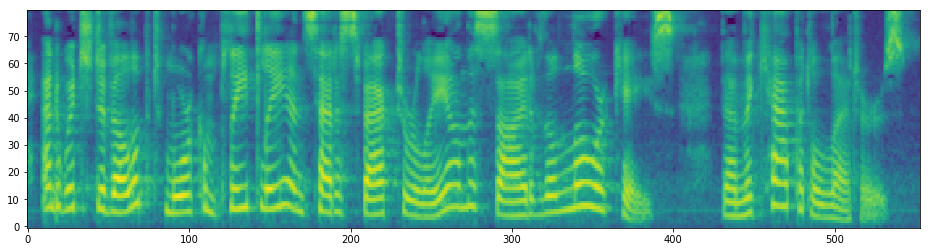

In [ ]:
for k in tqdm(metadata.keys()):
    text, char_seq, phone_seq, melspec, wav = save_file(k)
    if k == 'LJ001-0019':
        print("Text:")
        print(text)
        print()
        print("Melspectrogram:")
        plt.figure(figsize=(16,4))
        plt.imshow(melspec, aspect='auto', origin='lower')
        plt.show()